In [1]:
setwd("C:/Users/User/OneDrive/Documentos")
source("Meus Arquivos/Códigos/Funções.R")

In [2]:
options(warn = -1, scipen = 999)
pacotes <- c("dplyr","tidyr","tidyquant","BatchGetSymbols")
for(i in pacotes){
    suppressPackageStartupMessages(library(i, character.only = T))
}

In [3]:
#Todas as ações do Ibovespa atualmente
ibov_ticks <- GetIbovStocks()
acoes <- sort(ibov_ticks$tickers)
acoes <- paste0(acoes,".SA")
acoes <- c("^BVSP",acoes)

In [4]:
#Coletando os preços das ações e colocando em mesma escala
precos <- tq_get(acoes, from = Sys.Date()-365)
precos_mat <- precos %>%
  select(date, symbol, adjusted) %>%
  group_by(symbol) %>%
  summarise(date,adjusted = adjusted/first(adjusted)) %>%
  spread(key = symbol, value = adjusted)
datas <- precos_mat$date
precos_mat$date <- NULL
precos_mat <- as.matrix(precos_mat)
acoes <- acoes[-which(acoes == "^BVSP")]

`summarise()` regrouping output by 'symbol' (override with `.groups` argument)



In [5]:
#Pegando os dados do Ibovespa
ibov <- precos_mat[,"^BVSP"]

In [43]:
#Parâmetros da simulação
n_sim <- 4000
n_acoes <- 30
pesos <- pesos_carteira(n_acoes = n_acoes, n_sim = n_sim, short = F)
acoes_s <- matrix(0, nrow = n_acoes, ncol = ncol(pesos))
for(i in 1:ncol(acoes_s)){
  acoes_s[,i] <- sample(1:length(acoes), n_acoes)
}

In [44]:
carteiras <- matrix(0,nrow = nrow(precos_mat), ncol = ncol(pesos))
#Número de simulações
ncol(carteiras)

[1] 4000

In [45]:
for(i in 1:nrow(carteiras)){
  for(j in 1:ncol(carteiras)){
    carteiras[i,j] <- sum(precos_mat[i,acoes_s[,j]]*pesos[,j])
  }
}

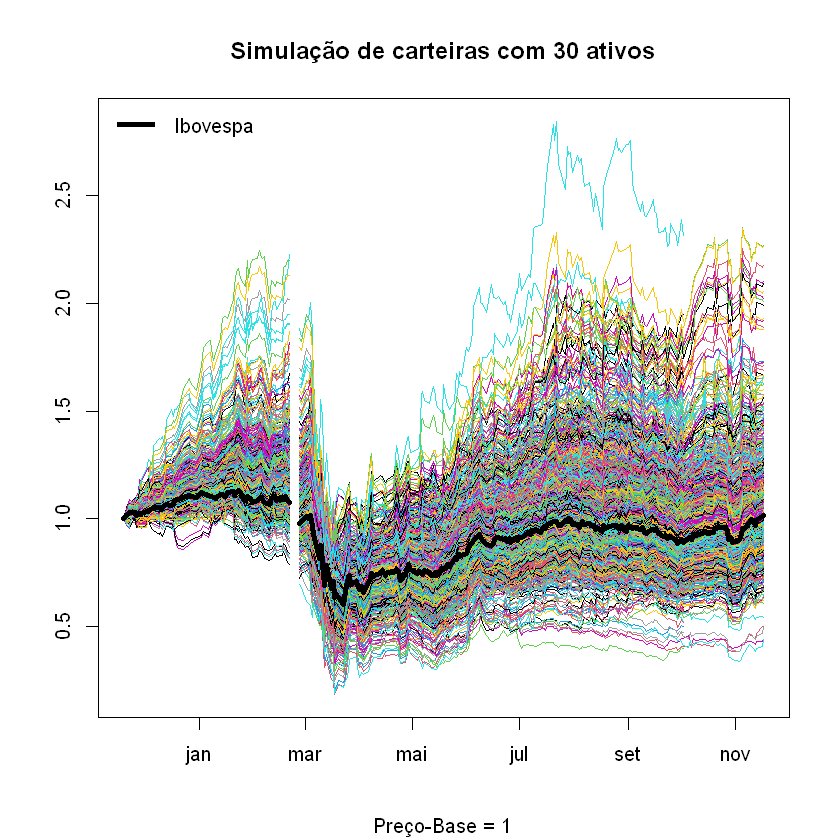

In [46]:
matplot(datas,carteiras, type = "l", lty = 1, col = 1:n_sim, xlab = "", ylab = "",
       main = paste("Simulação de carteiras com",n_acoes,"ativos"), sub = "Preço-Base = 1")
lines(datas,ibov, lwd = 4)
legend("topleft", legend = "Ibovespa", col = "black", lty = 1,
       lwd = 4, bty = "n")

In [47]:
maior <- which.max(carteiras[nrow(carteiras),])

In [48]:
#Carteira de maior retorno
p <- round(pesos[,maior]*100,2)
a <- acoes_s[,maior]
a <- acoes[a]
names(p) <- a
print(p)

 CVCB3.SA  BRFS3.SA  EMBR3.SA  USIM5.SA  EZTC3.SA  CIEL3.SA  UGPA3.SA ENGI11.SA 
     0.44      0.08      0.08      0.00      0.06      0.10      4.02      0.29 
BPAC11.SA  CRFB3.SA  GNDI3.SA  BBSE3.SA  YDUQ3.SA  EGIE3.SA  MRFG3.SA  FLRY3.SA 
     0.06      0.00      0.28      0.05     77.72      0.16      0.03      0.41 
 MULT3.SA  BEEF3.SA  AZUL4.SA  BRKM5.SA  BBDC4.SA  TOTS3.SA  CYRE3.SA  BRML3.SA 
     0.22      0.03      0.78      0.26      0.59      0.05      0.37      0.18 
 LREN3.SA  BBAS3.SA  VALE3.SA  ENBR3.SA  VVAR3.SA  ELET6.SA 
     3.26      9.13      0.12      0.09      0.13      1.03 


In [49]:
#Dados da carteira
ret <- diff(carteiras[,maior])/carteiras[2:nrow(carteiras)-1,maior]
sd_c <- c(sd(ret, na.rm = T)*sqrt(252),carteiras[nrow(carteiras),maior]-1)
names(sd_c) <- c("Volatilidade anual do período","Retorno no Período")
print(sd_c)

Volatilidade anual do período            Retorno no Período 
                           NA                      1.412739 


In [50]:
sd_t <- numeric(ncol(pesos))
sharpe <- numeric(ncol(pesos))
for(i in 1:length(sd_t)){
  ret <- (diff(carteiras[,i])/carteiras[1:nrow(carteiras),i])
  sd_t[i] <- sd(ret,na.rm = T)*sqrt(252)
  sharpe[i] <- (mean(ret, na.rm = T)*252)/sd_t[i]
}
sharpe_m <- which.max(sharpe)

In [51]:
#Carteira com maior sharpe
r_m <- last(carteiras[,sharpe_m]-1)
sd_m <- sd_t[sharpe_m]
s_m <- sharpe[sharpe_m]
p_m <- round(pesos[,sharpe_m]*100,2)
a_m <- acoes_s[,sharpe_m]
a_m <- acoes[a_m]
names(sd_m) <- "Desvio da carteira"
names(r_m) <- "Retorno da carteira"
names(s_m) <- "Sharpe da Carteira"
names(p_m) <- a_m
sd_m
r_m
s_m

Desvio da carteira 
         0.5076363

Retorno da carteira 
           1.269893

Sharpe da Carteira 
           2.15123

In [52]:
#Pesos da carteira com maior sharpe
print(p_m)

BPAC11.SA  GOAU4.SA  ECOR3.SA  ELET3.SA  BRML3.SA SULA11.SA  MGLU3.SA KLBN11.SA 
     1.76      0.34      0.27      0.76      0.07      3.61      0.34      1.32 
 BTOW3.SA  CRFB3.SA  IRBR3.SA  QUAL3.SA  YDUQ3.SA  CSAN3.SA  EZTC3.SA  UGPA3.SA 
     1.20      2.04      0.46      0.17     70.57      3.11      0.38      0.15 
 GNDI3.SA  RADL3.SA  ABEV3.SA  BBAS3.SA  MULT3.SA  CPFE3.SA  VALE3.SA  BBSE3.SA 
     0.16      0.05      0.24      1.39      0.08      0.09      0.26      7.93 
 BRAP4.SA  MRFG3.SA  HYPE3.SA  NTCO3.SA  RENT3.SA  IGTA3.SA 
     0.29      0.39      0.26      0.40      0.08      1.84 


In [53]:
#% de carteiras que bateram o IBOVESPA no período
porc <- table(carteiras[nrow(carteiras),] >= ibov[length(ibov)], useNA = "no")
porc <- porc/sum(porc)
names(porc) <- c("Rendeu menos","Rendeu Mais")
porc

Rendeu menos  Rendeu Mais 
      0.4165       0.5835 

In [54]:
menor <- which.min(carteiras[nrow(carteiras),])
#Carteira de menor retorno
p_mn <- round(pesos[,menor]*100,2)
a_mn <- acoes_s[,menor]
a_mn <- acoes[a_mn]
names(p_mn) <- a_mn
print(p_mn)

 CVCB3.SA  VALE3.SA  AZUL4.SA  EMBR3.SA ENGI11.SA  PRIO3.SA  ITSA4.SA  GGBR4.SA 
     0.18      5.67      0.05      0.09      0.29      0.12     87.59      0.17 
 ELET3.SA  CPFE3.SA  TOTS3.SA  CSNA3.SA  IGTA3.SA BPAC11.SA  BBAS3.SA  HAPV3.SA 
     0.02      0.03      0.10      0.11      0.33      0.83      0.01      0.07 
 CMIG4.SA  ECOR3.SA  UGPA3.SA  ITUB4.SA  ELET6.SA  HGTX3.SA  PETR3.SA  PETR4.SA 
     0.01      0.08      0.02      1.56      0.04      0.03      0.10      0.31 
 YDUQ3.SA  BTOW3.SA  SBSP3.SA SANB11.SA  QUAL3.SA  RAIL3.SA 
     0.23      0.15      0.01      1.80      0.00      0.01 


In [55]:
#Dados da carteira
ret_mn <- diff(carteiras[,menor])/carteiras[1:nrow(carteiras),menor]
sd_c_mn <- c(sd(ret_mn, na.rm = T)*sqrt(252),carteiras[nrow(carteiras),menor]-1)
names(sd_c_mn) <- c("Volatilidade anual do período","Retorno no Período")
print(sd_c_mn)

Volatilidade anual do período            Retorno no Período 
                           NA                    -0.6653888 
